# Dissertation Proof-of-Concept

A system capable of determining whether the user is looking at the top or the bottom of a screen.

In [9]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import json
from rich import print

In [10]:
# Just some variables to make logging stuff look nicer 
INFO = "[[b green]+[/b green]]"
WARNING = "[[b yellow]*[/b yellow]]"
ERROR = "[[b red]![/b red]]"

# Load Dataset 

This project uses the [Gazecapture](https://gazecapture.csail.mit.edu/) dataset. This is quite a large dataset when fully extracted ~(1.45TB), so I recomend using an external drive unless you have a lot of storage space available. 

In [125]:
# Location of the dataset
DATASET_PATH = "/Volumes/x10-pro/gazecapture"

# Reduce the amount of data we're extracting from the dataset
DATASET_SIZE = 10
FRAME_COUNT = 10

IMAGE_RESOLUTION = (128, 128)

# Helper function to assist selecting valid files
def is_valid_file(filename: str) -> bool:
    return not filename.startswith("._") and not filename.endswith(".md") 

class DataPoint:
    def __init__(
        self, id: str, path: str = DATASET_PATH, frame_count: int = FRAME_COUNT
    ):
        """
        Load the datapoint from a directory containing all of the information
        about the capture, this function does not respect parameters such as frame count, 
        and cleaning the data is necessary to make it usable
        :param id: The id of the datapoint to load
        :param path: Path to the dataset, i.e. `/path/to/gazecapture`. Defaults to `DATASET_PATH`
        :param frame_count: The number of frames to load, defaults to `FRAME_COUNT`
        """
        # TODO: Modify json loading logic so it respects FRAME_COUNT, and load into a numpy array 
        self.frame_count = frame_count
        self.frames = []
        
        with open(f"{path}/{id}/appleFace.json") as file:
            self.face = json.load(file)
        with open(f"{path}/{id}/appleLeftEye.json") as file:
            self.left_eye = json.load(file)
        with open(f"{path}/{id}/appleRightEye.json") as file:
            self.right_eye = json.load(file)
        with open(f"{path}/{id}/dotInfo.json") as file:
            self.dot_info = json.load(file)
        with open(f"{path}/{id}/faceGrid.json") as file:
            self.facegrid = json.load(file)
        with open(f"{path}/{id}/info.json") as file:
            self.info = json.load(file)
        with open(f"{path}/{id}/motion.json") as file:
            self.motion = json.load(file)
        with open(f"{path}/{id}/screen.json") as file:
            self.screen = json.load(file)

        frame_files = list(filter(is_valid_file, os.listdir(f"{path}/{id}/frames")))

        for frame in frame_files[:self.frame_count]:
            img = cv2.imread(f"{path}/{id}/frames/{frame}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            self.frames.append(img)


    def get_frames_and_gt(self): 
        # returns a list containing frames and the corresponding dot position 
        data = []

        for idx, frame in enumerate(self.frames[:self.frame_count]):
            data.append([frame, (self.dot_info["XPts"][idx], self.dot_info["YPts"][idx])]) 

        return data

    def get_frames_and_gt_norm(self):
        data = self.get_frames_and_gt()
        res = self.get_frames_resolution() 

        for idx, frame_info in enumerate( data ): 
            normed_points = ( frame_info[1][0] / res[0], frame_info[1][1] / res[1] )
            data[idx][1] = normed_points
            data[idx][0] = cv2.resize(data[idx][0], IMAGE_RESOLUTION)

        return data

    def get_random_frame_idx(self):
        return np.random.randint(len(self.frames))

    def get_frames_resolution(self):
        return self.frames[0].shape

    def get_random_frame(self):
        return self.frames[self.get_random_frame_idx()]

In [126]:
try: 
    dataset_ids = os.listdir(DATASET_PATH)
except FileNotFoundError:
    print(f"{ERROR} Dataset not found, is the external drive plugged in?")

# Remove hidden files and license/readme files
dataset_ids = list(filter(
    is_valid_file,
    dataset_ids
))

np.random.shuffle(dataset_ids)
data = []

for id in dataset_ids[:DATASET_SIZE]: 
    data.append(DataPoint(id))

print(f"{INFO} Dataset loaded")

[+] Dataset loaded

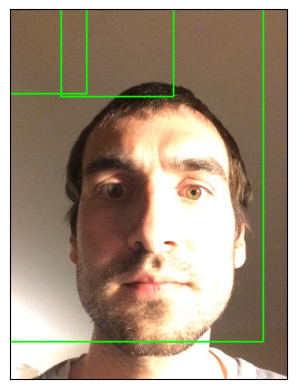

In [262]:
def visualize_img(datapoint, idx):
    """ 
    Given a datapoint from the dataset, and an idx, 
    display a box around the face, and eyes
    :param datapoint: The datapoint
    :param idx: The index of the frame to visualize
    """
    normed_data = datapoint.get_frames_and_gt() 
    img = normed_data[idx][0]
    
    face_box = {'x': datapoint.face["X"][idx], 'y': datapoint.face["Y"][idx], 'w': datapoint.face["W"][idx], 'h': datapoint.face["H"][idx]}
    l_eye_box = {'x': datapoint.left_eye["X"][idx], 'y': datapoint.left_eye["Y"][idx], 'w': datapoint.left_eye["W"][idx], 'h': datapoint.left_eye["H"][idx]}
    r_eye_box = {'x': datapoint.right_eye["X"][idx], 'y': datapoint.right_eye["Y"][idx], 'w': datapoint.right_eye["W"][idx], 'h': datapoint.right_eye["H"][idx]}

    b_boxes = [face_box, l_eye_box, r_eye_box]

    for bbox in b_boxes:
        x0 = bbox['x'] - bbox['w']
        x1 = bbox['x'] + bbox['w']
        y0 = bbox['y'] - bbox['h']
        y1 = bbox['y'] + bbox['h']

        start = (int(x0), int(y0))
        end = (int(x1), int(y1))

        cv2.rectangle(img, start, end, color=(0,255,0), thickness=2)

    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

def get_random_img_idx(dataset):
    dp_idx = np.random.randint(len(dataset))
    frame_idx = dataset[dp_idx].get_random_frame_idx()

    return (dp_idx, frame_idx)

idxs = get_random_img_idx(data)
visualize_img(data[idxs[0]], idxs[1])